# Enrichment of land-use/land-cover (LULC) data

This tool is aimed at the enrichment and rectification of commonly produced land-use/land-cover (LULC) raster data with auxiliary data from other sources. While these products pick up local spatial features mostly at high level of confidence, storaging data in raster format, providing quick and reliable access, they might lack some important human-made and natural spatial features, for example, narrow roads not detected due to the raster spatial resolution or waterways overshadowed by the vegetation. At the same time, these features can be extremely useful for multiple purposes, including ecological moitoring and conservation science, because roads, railways or even waterways can act as ecological barriers and prevent species to pass through them and migrate to other habitats. The workflow described below has been established to effectively enrich LULC data.
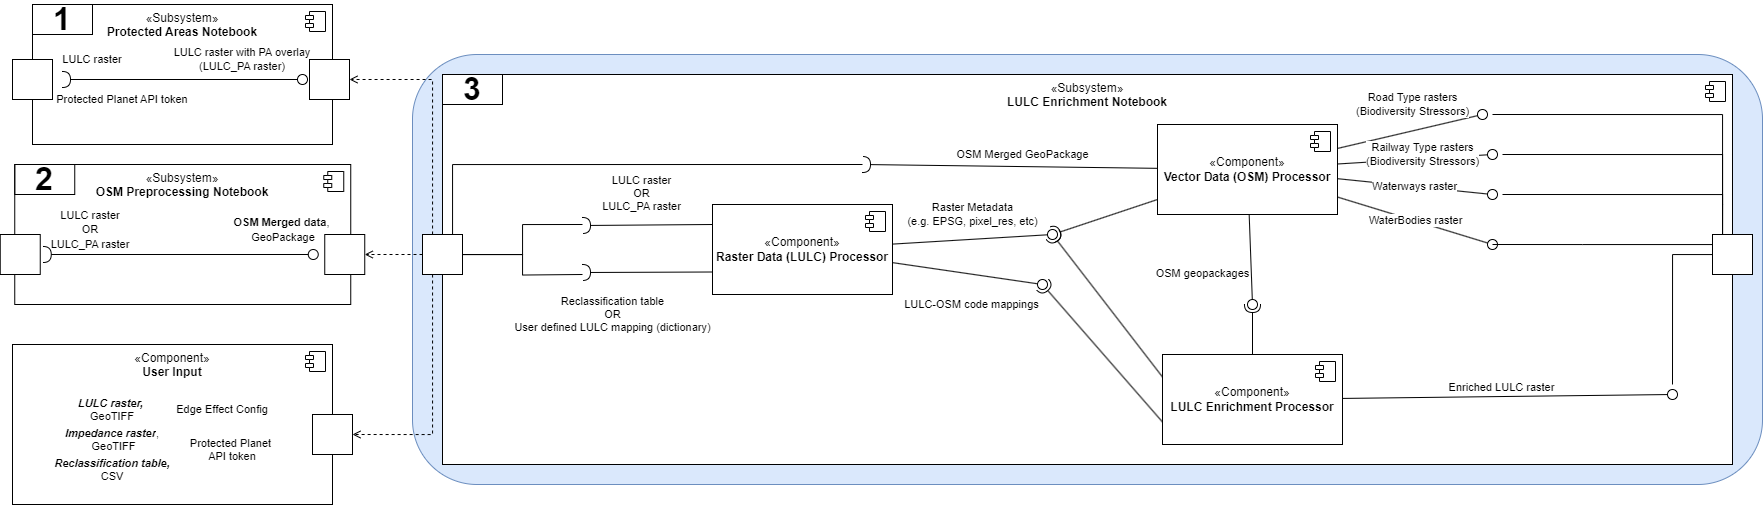

Currently, this workflow has been successfully applied to enrich [MUCSC maps of Catalonia, Spain](https://www.mcsc.creaf.cat/index_usa.htm), [LCM (Land Cover Maps) by UKCEH (UK Centre for Ecology and Hydrology)](https://www.ceh.ac.uk/data/ukceh-land-cover-maps) and [Sentinel LULC](https://collections.sentinel-hub.com/impact-observatory-lulc-map/) with spatial resolution of 30, 25 and 10 m respectively. The sample of last dataset is provided along with the Data4Land tool.

### Configuration

#### Input data

Firstly, it is vital to define input data, file names and paths to them. This block also defines Open Street Map (OSM) data or user-specified vector data to refine raster data.
The following types of input data are exploited:
1. Raster land-use/land-cover (LULC) data, GeoTIFF format. Cloud Optimised GeoTiff (COG) is preferable (COG with LZW compression is used to optimise storaging data). ***MANDATORY***
2. Vector data (GPKG) to enrich and refine LULC data (currently, roads, railways, water bodies and waterways are processed) derived either from OSM or user-specified data. ***MANDATORY***
3. Tabular (CSV) data mapping LULC types to their specifications: (1) whether concrete LULC type should be refined by vector data or not (***MANDATORY***) and (2) whether negative "edge effect" of concrete LULC type should be considered, for instance, roads affect suitability of habitats alongside roads (***OPTIONAL***). This reclassification table is being used in the [first block](1_protected_areas/1_preprocessing_pas.ipynb) of the Data4Land tool.

#### Importing all dependencies

In [ ]:
import numpy as np
import numpy.ma as ma
import geopandas as gpd
import fiona
import timing

# auxiliary libraries
import subprocess
from subprocess import Popen, PIPE
import warnings
import yaml
import os
from osgeo import ogr, osr, gdal

# for appending scripts and functions
import sys

# local modules
import text_matching
from vector_proc import VectorTransform
from reprojection import RasterTransform
from utils import load_yaml,extract_layer_names,extract_attribute_values, get_lulc_template
from raster_metadata import RasterMetadata
import timing
timing.start()

## Buffering vector features

This block below handles buffering roads and railways from the input vector dataset. This step is imperative for wide roads and railways, which can act as barriers that disrupt wildlife migrations.

In [ ]:
class vector_data_preprocessor():
    """
    Preprocesses OSM vector data for rasterization, which includes reprojecting, fixing geometries 
    and buffering features in biodiversity stressor layers (roads and railways).
    """
    def __init__(self, config: dict, parent_dir:str, vector_dir:str, year:int, lulc_crs:int, lulc_is_cartesian:bool) -> None:
        """
        Initializes the vector data preprocessor. Extracts vector layer names and checks if the CRS of the vector data matches the LULC data.

        Args:
            config (dict): configuration file
            parent_dir (str): parent directory
            vector_dir (str): vector directory
            year (int): year of the data
            lulc_crs (int): LULC CRS
            lulc_is_cartesian (bool): whether the LULC data is in cartesian coordinates
        """
        self.config = config
        self.year = year
        self.lulc_crs = lulc_crs
        self.lulc_is_cartesian = lulc_is_cartesian
        self.vector_refine = self.load_auxillary_data(parent_dir, vector_dir, year)
        print(f"Path to the input vector dataset: {self.vector_refine}")
        self.vector_layer_names = self.check_vector_data(self.vector_refine, self.lulc_crs)
        # specify the output directory
        self.vector_railways_buffered = os.path.join(parent_dir,vector_dir, f"railways_{self.year}_buffered.gpkg")
        self.vector_roads_buffered = os.path.join(parent_dir,vector_dir, f"roads_{self.year}_buffered.gpkg")
    
    def load_auxillary_data(self,parent_dir:str, vector_dir:str, year:int) -> str:
        """
        Loads the auxiliary data (OSM or user-specified vector data) from the configuration file.

        Args:
            parent_dir (str): parent directory
            vector_dir (str): vector directory
            year (int): year of the data

        Returns:
            str: filename of the auxiliary data
        """
        # specify input vector data
        osm_data_template = self.config.get('osm_data', None)
        vector_filename = None # define a new variable which will be equal either osm_data or user_vector (depending on the configuration file)
        if osm_data_template is not None:
            osm_data = osm_data_template.format(year=year)
            user_vector = None
            vector_filename = osm_data 
            print ("Input raster dataset will be enriched with OSM data.")
        else:
            warnings.warn("OSM data not found in the configuration file.") 
            user_vector_template = self.config.get('user_vector',None)
            if user_vector_template is not None:
                user_vector = user_vector_template.format(year=year)
                vector_filename = user_vector
                print ("Input raster dataset will be enriched with user-specified data.")
            else:
                raise ValueError("No valid input vector data found. Neither OSM data nor user specified data found in the configuration file.")
            
        # print the name of chosen vector file
        print(f"Using vector file to refine raster data: {vector_filename}")
        return os.path.normpath(os.path.join(parent_dir,vector_dir,vector_filename))
    

    def check_vector_data(self, vector_refine:str, crs:int) -> list:
        """
        Checks if the CRS of the vector data matches the input (LULC) data. If not, reprojects the vector data.

        Args:
            vector_refine (str): input vector file
            crs (int): CRS of the LULC data

        Returns:
            list: list of vector layer names
        """
        vector_layer_names = extract_layer_names(vector_refine) 
        print(f"Layers found in the input vector file: {vector_layer_names}")
        formatted_layers = ', '.join(vector_layer_names)  # join layer names with a comma and space for readability
        print(f"Please continue if the layers in the vector file listed below are correct:\n {formatted_layers}.")

        # define full path with vector input directory
        # split path on last occurence of '/' and take the first part
        filepath = os.sep.join(vector_refine.split(os.sep)[:-1])
        vector_refine_path = os.path.join(filepath)

        # check if crs matches input raster (lulc). If not, reproject the vector data
        Vt = VectorTransform(vector_refine_path)
        files_to_validate = Vt.reproject_vector(crs, overwrite=True)
        if len(files_to_validate) > 0:
            Vt.fix_geometries_in_gpkg(Vt.geom_valid(files_to_validate), overwrite=True)
        return vector_layer_names
    
    def buffer_features(self, layer:str, output_filepath:str, epsg:int=27700):
        """
        Buffer the features in the input vector layer based either on config file or 'width' column.
        If the instance is not in cartesian coordinates, a temporary transformation is used to apply the buffer in meters and then transform back to the original CRS.
        
        Args:
            layer (str): layer name
            output_filepath (str): output file path
            epsg (int, optional): EPSG code. Defaults to 27700.
        
        Returns:
            None
        """
        if os.path.exists(output_filepath):
            os.remove(output_filepath)

        # bring custom values of buffer width from the configuration file
        self.width_lev1 = self.config.get('width_lev1')
        self.width_lev2 = self.config.get('width_lev2')
        self.width_other = self.config.get('width_other')

        # check if the "width" column exists
        check_column_query = f"""
            SELECT COUNT(*) 
            FROM pragma_table_info('{layer}')
            WHERE name = 'width';
        """
        ogr_check_command = [
            'ogrinfo',
            self.vector_refine,
            '-dialect', 'SQLite',
            '-sql', check_column_query
        ]

        try:
            result = subprocess.run(ogr_check_command, check=True, capture_output=True, text=True)
            # extract the COUNT(*) value from the output
            column_exists = False
            for line in result.stdout.splitlines():
                 if "COUNT(*)" in line and "=" in line:  # Ensure the line contains COUNT(*) and an equals sign
                    count_value = int(line.split('=')[-1].strip())  # extract the number after '='
                    column_exists = count_value > 0  # set to true if count is greater than 0
                    break

        except Exception as e:
            column_exists = False
            return
            
        # build an SQL query to apply buffer based on "width" column and parameters from the config file
        if column_exists:
            print("Width column exists in subset.")
            subquery = f"""
                CASE 
                    WHEN "width" IS NULL OR CAST("width" AS REAL) IS NULL THEN 
                        CASE 
                            WHEN highway IN ('motorway', 'motorway_link', 'trunk', 'trunk_link') THEN {self.width_lev1}/2
                            WHEN highway IN ('primary', 'primary_link', 'secondary', 'secondary_link') THEN {self.width_lev2}/2
                            ELSE {self.width_other}/2 
                        END 
                    ELSE CAST("width" AS REAL)/2 
                END
            """
        else: # if 'width' is not specified
            print("Width column does not exist in subset. Using the custom value of width from the configuration file...")
            subquery = f"""{self.width_other}/2"""

        # DEBUG: print(subquery)
            
        # if it is not in cartesian coordinates, transform the geometry to a temporary cartesian CRS for buffering and then back to the original CRS
        # print(self.lulc_is_cartesian)
        if self.lulc_is_cartesian == False:
            query = f"""
                ST_Transform(
                    ST_Buffer(
                        ST_Transform(geom, {epsg}),
                        {subquery}
                    ),
                    {self.lulc_crs}
                ) AS geometry,
                *
            """
        else:
            query = f""" ST_Buffer(geom, {subquery}) AS geometry, * """

        # DEBUG: print(query)

        print(f"Buffering {layer} layer...")
        #NOTE only for roads and railways for now
        ogr2ogr_command = [
            'ogr2ogr',
            '-f', 'GPKG',
            output_filepath, # output file path
            self.vector_refine, # input file path (should be before the SQL statement)
            '-dialect', 'SQLite',
            '-sql', f"""
                SELECT
                {query}
                FROM {layer}; /* to specify layer of input file */
            """,
            '-nln', layer, # define layer in the output file
            '-nlt', 'POLYGON' # ensure the output is a polygon
        ]

        # execute ogr2ogr command
        try:
            result = subprocess.run(ogr2ogr_command, check=True, capture_output=True, text=True)
            print(f"Successfully buffered {layer} layer and saved to {output_filepath}.")
            if result.stderr:
                print(f"Warnings or errors:\n{result.stderr}")
        except subprocess.CalledProcessError as e:
            print(f"Error buffering roads: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error: {str(e)}")

        print("-"*40)

## Mapping LULC codes with auxiliary data

This block below, handles mapping LULC codes to vector data using auxiliary tabular data from the impedance file defined in the config.
The Lulc raster metadata is also extracted to compare with the vector data and for rasterization.

Currently, users can either:
- specify how main types of OSM features correspond with LULC codes from input raster dataset (for example, what LULC code roads should be assigned with) or
- use text-matching tool called from the external Python script.
The first option is recommended as variety of LULC types descriptions and languages used is vast.

In [4]:
class lulc_data_preprocessor():
    """
    Preprocesses LULC raster data for rasterization, 
    which includes mapping LULC codes with auxiliary data and extracting raster metadata.
    """
    def __init__(self, config:dict, lulc_dir:str, parent_dir:str) -> None:
        """
        Initializes the LULC data preprocessor. Maps LULC codes to OSM features and extracts raster metadata.

        Args:
            config (dict): configuration file
            lulc_dir (str): LULC directory
            parent_dir (str): parent directory
        """
        
        self.config = config
        print(f"Path to the input raster dataset: {lulc_dir}")

        impedance_file = self.config.get('impedance', None)
        impedance_dir = self.config.get('impedance_dir', None)

        if impedance_file is not None and impedance_dir is not None:
            # define path
            impedance_file = os.path.join(parent_dir,impedance_dir,impedance_file)
            print(f"Using auxiliary tabular data from {impedance_file}.")
        else:
            warnings.warn("auxiliary tabular data was not provided.")

        # map LULC codes to OSM features 
        self.lulc_codes = self.lulc_mapping(impedance_file)
        self.raster_metadata = RasterMetadata.from_raster(lulc_dir)

    def lulc_mapping(self, impedance_file:str):
        """
        Map LULC codes to OSM features using either user-defined mapping or text-matching tool with the impedance file.

        Args:
            impedance_file (str): path to the impedance file
        
        Returns:
            dict: dictionary containing LULC codes and corresponding OSM features
        """
        # find out from config file if user wants define LULC codes on their own, or use text-matching tool
        user_matching = self.config.get('user_matching')
      
        # if user defines mapping on their own
        if user_matching.lower() == 'true': # case-insensitive condition
            # access variables and subvariables from the confiration file
            lulc_codes = self.config.get('lulc_codes', {})
            # print codes of areas from OSM corresponding with LULC codes from input raster dataset
            print("User-specified mapping of LULC codes and OSM features is used.")
            print("LULC dictionary:", lulc_codes)

        # if user defines mapping from text-matching tool
        elif user_matching.lower() == 'false': # case-insensitive condition
            # call the function and capture the result
            lulc_codes = text_matching.codes(self.config, impedance_file)
            # print codes of areas from OSM corresponding with LULC codes from input raster dataset
            print("Text matching tool used to map LULC codes and corresponding OSM features.")
            print("LULC dictionary:", lulc_codes)
        else:
            raise ValueError("User did not specify mapping between OSM features and LULC types.")
        
        return lulc_codes

# Merging the Rasters

This block uses the preprocessors above to merge LULC and input vector data into a single raster dataset. The vector dataset is also rasterized into GeoTiffs for each layer, with the roads layer being further separated into road type GeoTiffs.
Users can optionally choose to save the vector impedance stressors to the temporary configuration file for an optional impedance recalcuation step in the next [Jupyter Notebook](4_impedance.ipynb).

In [ ]:
class lulc_enrichment_processor():
    """
    Uses preprocessors to prepare LULC and OSM data for rasterization, 
    then rasterizes vector data and merges both rasters into a single raster dataset.
    """
    
    def __init__(self, config:dict, parent_dir:str, lulc:str, year:int) -> None:
        """
        Initializes the LULC enrichment processor.

        Args:
            config (dict): configuration dictionary
            parent_dir (str): parent directory
            lulc (str): LULC raster dataset
            year (int): year of the data
        """
        self.config = config
        self.year = year
        self.parent_dir = parent_dir
        self.vector_dir = self.config.get('vector_dir')
        self.output_dir = self.config.get('output_dir')
        self.lulc = lulc

    def prepare_lulc_osm_data(self):
        """
        Prepares the LULC and OSM data for rasterization and merging into a single raster dataset.
        """
        ## LULC PREPROCESSING
        self.lp = lulc_data_preprocessor(self.config, self.lulc, self.parent_dir)
        
        ## OSM PREPROCESSING
        self.vp = vector_data_preprocessor(self.config, self.parent_dir, self.vector_dir, self.year,self.lp.raster_metadata.crs_info["epsg"], self.lp.raster_metadata.is_cartesian)
        # buffer features in the input vector data
        self.vp.buffer_features('railways', self.vp.vector_railways_buffered, self.vp.lulc_crs)
        self.vp.buffer_features('roads', self.vp.vector_roads_buffered, self.vp.lulc_crs)

    def merge_lulc_osm_data(self, save_osm_stressors:bool=False):
        """
        Merges the LULC and OSM data into a single raster dataset.

        Args:
            save_osm_stressors (bool): flag to save the OSM stressors to a file for impedance recalculation
        """
        ## rasterize vector layers
        self.rasters_temp = self.rasterize_vector_layers(save_osm_stressors)

        # merge rasters
        lulc_upd = os.path.normpath(os.path.join(self.parent_dir,self.output_dir,f'lulc_{self.year}_upd.tif'))
        # TODO - to inherit the initial filename of input raster
        
        # TODO REMOVE to print the output filename
        print(f"Enriched land-use/land-cover dataset(s) will be fetched to {lulc_upd}")
        # TODO REMOVE debug: print dimensions for each raster to check them against LULC dimension
        self.check_raster_dimensions([self.lulc, *self.rasters_temp])
        # self.rasters_temp: /data/data/output/waterbodies_2017.tif /data/data/output/waterways_2017.tif /data/data/output/roads_2017.vrt /data/data/output/railways_2017.tif

        # overwrite rasters over input dataset in the following order: waterbodies, waterways, roads, railways
        output_data, output_ds, nodata_value = self.overwrite_raster(self.lulc, *self.rasters_temp)
        self.write_raster(output_data, output_ds, lulc_upd, nodata_value)

    def merge_tiffs_into_vrt(self, tiffs:list, output_path:str):
        """
        Merge multiple raster datasets into a single VRT file.

        Args:
            tiffs (list): list of paths to the raster datasets
            output_path (str): path to the output VRT file

        Returns:
            None
        """
        # write the list to a new file (path to the file is ../data/list_of_tiff_files.txt)
        tiffs_filepaths = output_path.replace('.vrt', '_tiffs.txt')
        with open(tiffs_filepaths, "w") as f:
            for item in tiffs:
                f.write(item + "\n")

        gdal_command = f"""gdalbuildvrt -input_file_list {tiffs_filepaths} {output_path}"""
        proc = Popen(gdal_command, shell=True, stdout=PIPE, stderr=PIPE)
        stdout, stderr = proc.communicate()
        # remove the list of tiff files
        os.remove(tiffs_filepaths)

        if proc.returncode != 0:
            print(proc.returncode)
            print("STDERR:", stderr.decode())
            raise Exception("Error creating VRT")

    # @DeprecationWarning
    def check_raster_dimensions(self, listraster_uri:list): 
        for raster_path in listraster_uri:
            dataset = gdal.Open(raster_path)
            if dataset:
                width = dataset.RasterXSize
                height = dataset.RasterYSize
            else:
                raise ValueError(f"Unable to open raster file: {raster_path}")
            print(f"Dimensions of {os.path.basename(raster_path)}: {width} x {height}")


    def write_raster(self, output_data:any, output_ds:any, output_raster:str, nodata_value:int):
        """
        Write a new raster dataset from the given data array.

        Args:
            output_data (np.array): data array to write to the raster
            output_ds (gdal.Dataset): dataset of the input raster
            output_raster (str): path to the output raster dataset
            nodata_value (int): no data value for the output raster

        Returns:
            None
        """

        # get the driver to write a new GeoTIFF
        driver = gdal.GetDriverByName('GTiff')
        out_ds = driver.Create(output_raster, output_ds.RasterXSize, output_ds.RasterYSize, 1, gdal.GDT_Byte)

        # set geo-transform and projection from the input raster
        out_ds.SetGeoTransform(output_ds.GetGeoTransform())
        out_ds.SetProjection(output_ds.GetProjection())

        # write the data to the output raster
        out_band = out_ds.GetRasterBand(1)
        out_band.WriteArray(output_data)

        # set nodata value 
        out_band.SetNoDataValue(nodata_value)

        # flush the data and close files
        out_band.FlushCache()
        out_ds = None  # close the file
        output_ds = None  # close the input file

        print(f"Output raster saved to {output_raster}")

    def new_layer_from_attributes(self, vector_gpkg:str, layer_name:str, attribute:str, value:str, output_gpkg:str):
        """
        Create a new layer from the input layer based on the attribute value.

        Args:
            vector_gpkg (str): path to the input vector GeoPackage file
            layer_name (str): name of the layer to extract features from
            attribute (str): attribute name to filter by
            value (str): value to filter by
            output_gpkg (str): path to the output GeoPackage file

        """
        print("Layer to access:", layer_name)
        ogr_command = f"""
            ogr2ogr -f GPKG {output_gpkg} {vector_gpkg} -sql "SELECT * FROM {layer_name} WHERE {attribute} LIKE '%{value}%'"
        """
        # DEBUG: print the command to extract the subtypes of stressors from the vector dataset
        print(f"The following command to extract features:\n{ogr_command}")
        proc = Popen(ogr_command, shell=True, stdout=PIPE, stderr=PIPE)
        stdout, stderr = proc.communicate()
        if proc.returncode != 0:
            raise RuntimeError(stderr)
        print(f"New layer saved to {output_gpkg}")

        # TODO - probably to move from PIPE to subprocess.run as takes more time

        # # define ogr2ogr command
        # ogr2ogr_cmd = [
        #     'ogr2ogr',
        #     '-f', 'GPKG',
        #     output_gpkg,
        #     vector_gpkg,
        #     '-dialect', 'SQLite',
        #     '-sql', sql_statement
        # ]

        # # execute ogr2ogr command through subprocess
        # subprocess.run(ogr2ogr_cmd, check=True)
        
        return output_gpkg
   
    def rasterize_vector_roads(self, raster_metadata:str , roads_gpkg:str, burn_value:int, groupby_roads:bool=True):
        """
        Rasterize roads vector layer to be used for enriching the LULC dataset.

        Args:
            raster_metadata (RasterMetadata): object containing raster metadata (extent, cell size, etc.)
            roads_gpkg (str): path to the roads GeoPackage file
            burn_val (int): value to burn into the output raster 
        Returns:
            dict: dictionary containing road type stressors.
        """

        #extract road types from roads geopackage

        #NOTE we hard code the layer name since we know it is roads
        # road_layer_name = [layer for layer in self.vp.vector_layer_names if 'road' in layer.lower()][0]
        road_layer_name = 'roads'
        road_types = extract_attribute_values(roads_gpkg, road_layer_name, attribute='highway')
        print(f"Road types found in the input vector file: {road_types}")

        #group attributes by first suffix (e.g. primary, secondary, tertiary) split by '_'
        if groupby_roads:
            road_types = list(set([road_type.split('_')[0] for road_type in road_types]))
            print(f"Road types to be rasterized: {road_types}")
        
        # for each road type, rasterize the roads
        road_tiffs = []
        for road_type in road_types:
            # create a new layer for each road type
            output_path = os.path.join(self.parent_dir,self.output_dir,f'roads_{road_type}.gpkg')
            road_gpkg = self.new_layer_from_attributes(roads_gpkg, road_layer_name, 'highway', road_type, output_path)
            # edit roads path to include road type
            output_path = output_path.replace('.gpkg', f'_{self.year}.tif')
            self.rasterize_vector_layer(raster_metadata, road_gpkg, output_path, nodata_value=0, burn_value=burn_value, layer_name=f'roads_{road_type}')
            # delete the temporary layer
            os.remove(road_gpkg)
            road_tiffs.append(output_path)

        
        # build a roads.vrt file to merge all road types
        self.merge_tiffs_into_vrt(road_tiffs, os.path.join(self.parent_dir,self.output_dir,f'roads_{self.year}.vrt')) 
        return {'roads':road_types}

    def rasterize_vector_layers(self, save_osm_stressors:bool=False):
        """
        Rasterize all vector layers to be used for enriching the LULC dataset.

        Args:
            save_osm_stressors (bool): flag to save the OSM stressors to a file for impedance recalculation
            
        Returns:
            list: list of paths to the rasterized layers
        """
        roads = os.path.join(self.parent_dir,self.output_dir,f'roads_{self.year}.vrt') # TO CHANGE
        railways = os.path.join(self.parent_dir,self.output_dir,f'railways_{self.year}.tif')
        waterbodies = os.path.join(self.parent_dir,self.output_dir,f'waterbodies_{self.year}.tif')
        waterways = os.path.join(self.parent_dir,self.output_dir,f'waterways_{self.year}.tif')
        rasters_temp = [waterbodies, waterways, roads, railways] # Order is important for next steps
        
        # rasterize roads and railways from buffered geometries
        osm_impedance_stressor_types = self.rasterize_vector_roads(self.lp.raster_metadata, self.vp.vector_roads_buffered, burn_value=self.lp.lulc_codes["lulc_road"], groupby_roads=True)
        self.rasterize_vector_layer(self.lp.raster_metadata,self.vp.vector_railways_buffered, railways, nodata_value=0, burn_value=self.lp.lulc_codes["lulc_railway"])
        # add railway to stressors (because there is no railway type processing we use None)
        osm_impedance_stressor_types['railways'] = None

        self.rasterize_vector_layer(self.lp.raster_metadata,self.vp.vector_refine, waterbodies, layer_name='waterbodies', nodata_value=0, burn_value=self.lp.lulc_codes["lulc_water"]) # read from the corresponding layer
        self.rasterize_vector_layer(self.lp.raster_metadata,self.vp.vector_refine, waterways, layer_name='waterways', nodata_value=0, burn_value=self.lp.lulc_codes["lulc_water"]) # read from the corresponding layer


        # write osm_stressors to file
        if save_osm_stressors == True:
            # Path is hardcoded since it is a temporary file
            with open("stressors.yaml" , 'w') as file:
                yaml.dump(osm_impedance_stressor_types, file, default_flow_style=True)
            print("OSM stressors saved to stressors.yaml for impedance recalculation.")

        return rasters_temp
    
    def rasterize_vector_layer(self,lulc:RasterMetadata, vector_path:str, output_path:str, nodata_value:str, burn_value:str, layer_name:str=None):
        """
        Rasterize a vector layer to a raster dataset.

        Args:
            lulc (Raster_Properites): object containing raster properties
            vector_path (str): path to the vector dataset
            output_path (str): path to the output raster dataset
            nodata_value (str): no data value for the output raster
            burn_value (str): value to burn into the output raster
            layer_name (str): name of the layer to rasterize (optional if there is more than one layer in the input file)

        Returns:
            str: path to the output raster dataset
        """
        # open the vector data source
        data_source = ogr.Open(vector_path)
        if data_source is None:
            raise RuntimeError(f"Failed to open the vector file: {vector_path}")

        # check the number of layers and write it to the variable
        layer_count = data_source.GetLayerCount()
        
        # define gdal_rasterize command
        #TODO get extent from lulc raster
        gdal_rasterize_cmd = [
            'gdal_rasterize',
            '-tr', str(lulc.cell_size), str(lulc.cell_size),  # output raster pixel size
            '-te', str(lulc.x_min), str(lulc.y_min), str(lulc.x_max), str(lulc.y_max),  # output extent 
            '-a_nodata', str(nodata_value),  # no_data value
            '-ot', 'Int16',   # output raster data type,
            '-burn', str(burn_value),  # burn-in value
            '-at',  # all touched pixels are burned in
            vector_path,  # input vector file
            output_path  # output raster file
        ]

         # add the layer name if there are multiple layers 
        if layer_count > 1: # specify layer name if using merged geopackage as an input file
            gdal_rasterize_cmd.insert(1, '-l')
            gdal_rasterize_cmd.insert(2, str(layer_name))

        # execute gdal_rasterize command through subprocess
        subprocess.run(gdal_rasterize_cmd, check=True, capture_output=True, text=True)

        # mask out data outside the extent of the input raster
        # self.mask_raster_with_raster(output_path, self.lulc, nodata_value)

        # compress output 
        output_compressed = output_path.replace('.tif', '_compr.tif')
        gdal_translate_cmd = [
            'gdal_translate',
            output_path,
            output_compressed,
            '-co', 'COMPRESS=LZW',
            '-ot', 'Byte'
        ]
        # execute gdal_translate command through subprocess
        subprocess.run(gdal_translate_cmd, check=True)

        # rename compressed output to original
        os.remove(output_path)
        os.rename(output_compressed, output_path)

        print("Rasterized output saved to:", output_path)
        print("-" * 40)
        return output_path

    def mask_raster_with_raster(self, input_raster, mask_raster, nodata_value, output_raster:str = None):
        """Masks an input raster with a mask raster.

        Args:
            input_raster: Path to the input raster.
            mask_raster: Path to the mask raster.
            output_raster: Output raster path. If None, the input raster will be overwritten.
            nodata_value: NoData value for the output raster.
        """

        # open input and mask rasters
        in_ds = gdal.Open(input_raster)
        mask_ds = gdal.Open(mask_raster)

        # get raster properties
        in_band = in_ds.GetRasterBand(1)
        mask_band = mask_ds.GetRasterBand(1)
        out_driver = gdal.GetDriverByName('GTiff')
        if output_raster is None:
            out_ds = gdal.Open(input_raster, gdal.GA_Update)
        else:
            out_ds = out_driver.Create(output_raster, in_ds.RasterXSize, in_ds.RasterYSize, 1, in_band.DataType)
            out_ds.SetProjection(in_ds.GetProjection())
            out_ds.SetGeoTransform(in_ds.GetGeoTransform())
        out_band = out_ds.GetRasterBand(1)

        # create a mask array from the mask raster
        mask_data = mask_band.ReadAsArray()
        mask_data[mask_data == 0] = nodata_value

        # apply the mask to the input raster
        in_data = in_band.ReadAsArray()
        out_data = in_data * mask_data # TODO - to rewrite to avoid multiplying mask (LULC) by rasterised vector features

        # write the masked data to the output raster
        out_band.WriteArray(out_data)
        out_band.SetNoDataValue(nodata_value)
        out_ds.FlushCache()

        # close datasets
        in_ds = None
        mask_ds = None
        out_ds = None

    # function to overwrite values from input raster by multiple rasters
    def overwrite_raster(self, base_raster:str, *rasters:str):
        """
        Merge multiple rasters by overwriting values from the base raster with valid data from other rasters.

        Args:
            base_raster (str): path to the base raster dataset
            *rasters (str): paths to other raster datasets to be merged
        
        Returns:
            np.array: merged raster dataset
            gdal.Dataset: dataset of the base raster
            float: nodata value of the base raster
        """
        # open the input raster and read it
        base_ds = gdal.Open(base_raster)
        base_band = base_ds.GetRasterBand(1)
        base_data = base_band.ReadAsArray().astype(np.float32)
        
        # get nodata value for the input raster
        nodata_value = base_band.GetNoDataValue()
        if nodata_value is None:  # if nodata value is not defined, set 0 as a default
            nodata_value = 0
        base_data[base_data == nodata_value] = np.nan  # replace nodata value with nan for processing
        print(f"Nodata value of the input raster dataset: {nodata_value}")
        
        # iterate over other rasters
        for raster in rasters:
            ds = gdal.Open(raster)
            band = ds.GetRasterBand(1)
            data = band.ReadAsArray().astype(np.float32)
            current_nodata = band.GetNoDataValue()
            if current_nodata is None:  # handle missing nodata value
                current_nodata = 0
            data[data == current_nodata] = np.nan  # replace nodata with nan for processing
            
            # overwrite values in base_data where current raster has valid data
            mask = ~np.isnan(data)
            base_data[mask] = data[mask]
        
        # after processing, replace NaNs with the nodata value before saving
        base_data[np.isnan(base_data)] = nodata_value
        
        return base_data, base_ds, nodata_value

# Pipeline Wrapper

This block wraps the above class to abstract the pipeline processes, this is because the pipeline is designed to only process a single year of lulc and vector data. Users must maunally add/change the year variable from the config file. \
*Looping over multiple years is not yet implemented.*

In [ ]:
class lulc_enrichment_wrapper():
    """
    Wrapper class for the LULC enrichment processor. 
    """
    def __init__(self, config_path:str, output_dir:str) -> None:
        """
        Initializes the LULC enrichment wrapper. Currently only processes data for a single year.

        Args:
            config_path (str): path to the configuration file
            output_dir (str): output directory
        """

        self.config = load_yaml(config_path)
        self.years = self.config.get('year', None)
        if self.years is None:
            warnings.warn("Year variable is null or not found in the configuration file... \n Defaulting to 2017")
            self.years = [2017]
        elif isinstance(self.years, int):
            self.years = [self.years]
        
        # substitute year from the configuration file
        year = self.years[0]
        lulc = get_lulc_template(self.config, year)

        print(f"Input raster to be used for processing is {lulc}.")

        parent_dir = os.getcwd()
        lulc_dir = self.config.get('lulc_dir')
        output_dir = self.config.get('output_dir')

        # create the output directory if it does not exist
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
            print(f"Created directory: {output_dir}")
        
        # specifying the path to input files through the path variables
        lulc = os.path.normpath(os.path.join(parent_dir,lulc_dir,lulc))
        self.adp = lulc_enrichment_processor(self.config, parent_dir,lulc,year)

In [7]:
lew = lulc_enrichment_wrapper('config.yaml', 'output')

Input raster to be used for processing is lulc_esa_2017.tif.


In [8]:
lew.adp.prepare_lulc_osm_data()

Path to the input raster dataset: /data/data/input/lulc/lulc_esa_2017.tif
Using auxiliary tabular data from /data/data/input/impedance/lulc_descr_esa.csv.
User-specified mapping of LULC codes and OSM features is used.
LULC dictionary: {'lulc_road': 7, 'lulc_railway': 7, 'lulc_water': 1}
Good news! The spatial resolution of your raster data is consistent between X and Y.
Input raster dataset /data/data/input/lulc/lulc_esa_2017.tif was opened successfully.
Coordinate reference system of the input raster dataset is EPSG:32630
x_min: 538670.0
x_max: 610530.0
y_min: 5883540.0
y_max: 5959790.0
Spatial resolution of input raster dataset (cell size): 10.0
Good news! The CRS of your input raster dataset is the Cartesian (projected) one.
Input raster dataset will be enriched with OSM data.
Using vector file to refine raster data: osm_merged_2017.gpkg
Path to the input vector dataset: /data/data/input/vector/osm_merged_2017.gpkg


/opt/venv/lib/python3.12/site-packages/osgeo/gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Layers found in the input vector file: ['railways', 'roads', 'waterbodies', 'waterways']
Please continue if the layers in the vector file listed below are correct:
 railways, roads, waterbodies, waterways.
Found 1 GeoPackage files in the directory: /data/data/input/vector.
CRS of the vector dataset 'osm_merged_2017.gpkg' is EPSG:32630.
Good news! CRS of the vector dataset 'osm_merged_2017.gpkg' matches the specified CRS: 32630.
Width column does not exist in subset. Using the custom value of width from the configuration file...
Buffering railways layer...
Successfully buffered railways layer and saved to /data/data/input/vector/railways_2017_buffered.gpkg.
----------------------------------------
Width column exists in subset.
Buffering roads layer...
Successfully buffered roads layer and saved to /data/data/input/vector/roads_2017_buffered.gpkg.
----------------------------------------


In [9]:
lew.adp.merge_lulc_osm_data(save_osm_stressors=True)

Layer name: roads
Road types found in the input vector file: {'primary_link', 'trunk_link', 'trunk', 'tertiary', 'motorway', 'secondary_link', 'motorway_link', 'tertiary_link', 'primary', 'secondary'}
Road types to be rasterized: ['trunk', 'motorway', 'tertiary', 'primary', 'secondary']
Layer to access: roads
The following command to extract features:

            ogr2ogr -f GPKG /data/data/output/roads_trunk.gpkg /data/data/input/vector/roads_2017_buffered.gpkg -sql "SELECT * FROM roads WHERE highway LIKE '%trunk%'"
        
New layer saved to /data/data/output/roads_trunk.gpkg
Input file size is 7186, 7625
0...10...20...30...40...50...60...70...80...90...100 - done in 00:00:06.
Rasterized output saved to: /data/data/output/roads_trunk_2017.tif
----------------------------------------
Layer to access: roads
The following command to extract features:

            ogr2ogr -f GPKG /data/data/output/roads_motorway.gpkg /data/data/input/vector/roads_2017_buffered.gpkg -sql "SELECT * FROM r

In [10]:
# call own module and finish calculating time
timing.stop()

Elapsed time: 170.96 seconds
